In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
config = {
    'img_size': 512,
    'epochs' : 25,
    'lr': 1e-2,
    'batch_size' : 16,
    'seed': 42
}

#### seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config['seed'])

In [5]:
train_add_df = pd.read_csv('clean_train.csv', index_col = 0)

In [6]:
train_add_df = train_add_df.drop([3023, 6068], axis = 0) #변환 과정에서 유실된 이미지

In [7]:
#data split
df = train_add_df.sample(frac=1)
train_len = int(len(df) * 0.9)

train = df[:train_len]
val = df[train_len:]

In [8]:
def get_labels(df):
    return df['cancer']

In [9]:
train_labels = get_labels(train)
val_labels = get_labels(val)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label, transforms=None):
        self.img_path_list = img_path_list
        self.label = label
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label is not None:
            label = self.label[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [14]:
train_transform = A.Compose([
                            A.Resize(config['img_size'],config['img_size']),
                            A.VerticalFlip(), #상하
                            A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT,p=0.1),
                            A.Normalize(mean=(0.23871402374634515, 0.23871402374634515, 0.23871402374634515),
                                        std=(0.15158960999600005, 0.15158960999600005, 0.15158960999600005), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(config['img_size'],config['img_size']),
                            A.Normalize(mean=(0.23871402374634515, 0.23871402374634515, 0.23871402374634515), 
                                        std=(0.15158960999600005, 0.15158960999600005, 0.15158960999600005), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [15]:
train_dataset = CustomDataset(train['image_id_path'].values, train_labels.values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['image_id_path'].values, val_labels.values, test_transform)
val_loader = DataLoader(val_dataset, batch_size = config['batch_size'], shuffle=False, num_workers=0)

In [16]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=1):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = F.sigmoid(self.classifier(x))
        return x

In [19]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    best_val_acc = 0
    best_model = None
    
    for epoch in range(1, config['epochs']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.float().to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_acc = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val ACC : [{_val_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_acc)
            
        if best_val_acc < _val_acc:
            best_val_acc = _val_acc
            best_model = model
    
    return best_model

In [20]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.float().to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels.reshape(-1,1))
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            val_acc.append(batch_acc)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_acc = np.mean(val_acc)
    
    return _val_loss, _val_acc

In [21]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = config["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1], Train Loss : [11.22387] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2], Train Loss : [9.76506] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5], Train Loss : [9.70247] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00007: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8], Train Loss : [9.63539] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10], Train Loss : [9.71183] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00010: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13], Train Loss : [13.89078] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00013: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00016: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18], Train Loss : [9.76796] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00019: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00022: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]


  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25], Train Loss : [9.63698] Val Loss : [10.86111] Val ACC : [0.89139]
Epoch 00025: reducing learning rate of group 0 to 3.9063e-05.


In [22]:
torch.save(infer_model.state_dict(), 'model_eff.pt')

### Grad CAM

In [93]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision
import torchvision.transforms as transforms # 이미지 변환 툴
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')    

img_path = train_add_df[train_add_df['cancer']==0]['image_id_path'].iloc[504] # 찍어보고 싶은 이미지 경로를 지정합니다.(28,  )

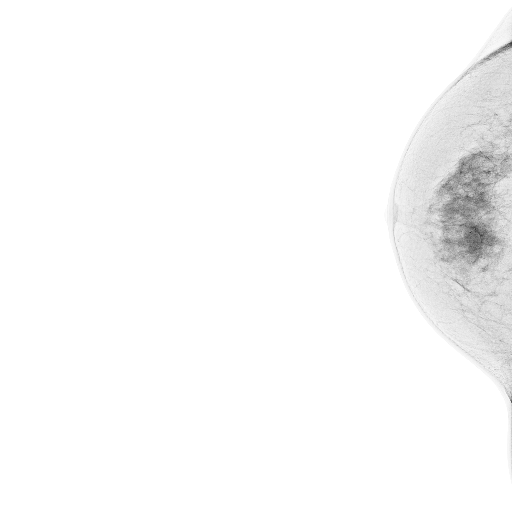

In [94]:
#원본 이미지 -> 모델이 어디에 집중 했을까?
image = cv2.imread(img_path, 1)
image_resized = cv2.resize(image, (512, 512))
Image.fromarray(image_resized[:, :, :3])

5355 4915 3


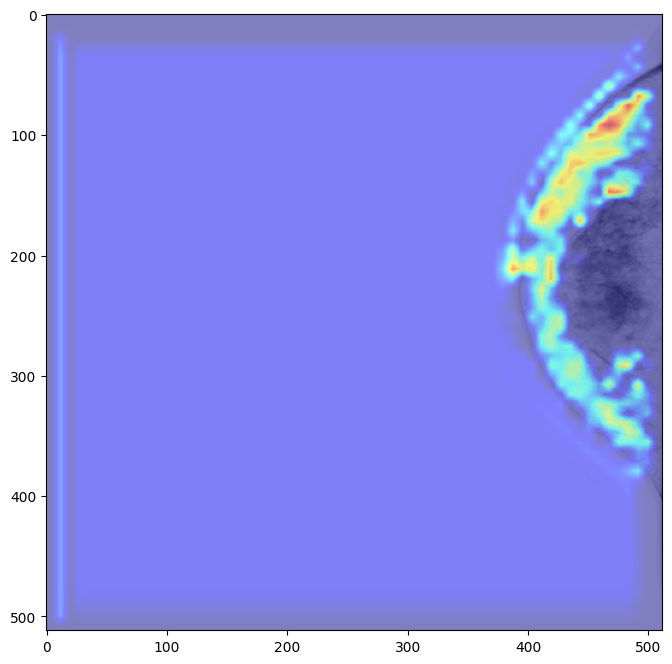

In [95]:
def get_img_tensor(img_path):
    img = cv2.imread(img_path)
    h, w, c = img.shape
    print(h, w, c)
    img = Image.fromarray(img[:, :, :3])
    img = torchvision.transforms.Resize((512,512))(img)
    img = torchvision.transforms.ToTensor()(img)
    img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
    img = img.unsqueeze(0)
    return img

model = BaseModel() 
device = torch.device('cpu')# 연산해줄 device를 선언 해 줍니다. cuda or cpu
model.load_state_dict(torch.load('model_eff.pt',map_location=device))

for param in model.parameters():
    param.requires_grad = False
                                 
target_layers = [model.backbone.features[4][0].block[0][0]]# CAM을 찍어볼 모델의 특정 레이어를 리스트 안에 넣어 사용합니다.
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False) # GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad처럼 다양한 툴을 사용할 수 있습니다.

img = get_img_tensor(img_path) # 이미지를 tensor로 변환합니다.
# image = plt.imread(img_path)
image = cv2.imread(img_path, 1)
image = Image.fromarray(image[:, :, :3])
image = np.float32(torchvision.transforms.Resize((512,512))(image)) / 255.0
output = model(img)
_, pred = torch.max(output, 1) #이미지에 대한 모델 예측값을 받아줍니다.
targets = [ClassifierOutputTarget(pred)] #이미지에 대한 예측값을 target으로 둡니다.

# CAM을 적용해 줍니다.
grayscale_cam = cam(input_tensor= img, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

In [63]:
import torchvision.transforms as transforms

test_transforms = transforms.Compose([transforms.Resize((512, 512)),# 이미지 리사이즈 
                                      transforms.ToTensor(), # 이미지를 텐서로
                                      transforms.Normalize(mean=[0.23871402374634515, 0.23871402374634515, 0.23871402374634515],
                                                           std=[0.15158960999600005, 0.15158960999600005, 0.15158960999600005])]) 

In [64]:
from torchvision.datasets import ImageFolder
test = ImageFolder(root='/home/user/Code/JE/BOAZ/cancer/validation', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test, batch_size=16, shuffle=True)

In [69]:
# cat dog 클래스 분류
classes = ['negative', 'positive']

In [87]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
criterion = nn.BCELoss().to(device)
batch_size = 16
model.eval()
with torch.no_grad():
    for data, target in testloader:
        data = data.float().to(device)
        target = target.float().to(device)

        # 데이터를 output에 삽입
        output = model(data)
        # loss율 계산
        loss = criterion(output, target.reshape(-1,1))
        # loss율 업데이트
        test_loss += loss.item()*data.size(0)
        # 1차원, 정답률 확인
        _, pred = torch.max(output, 1)    
        # pred와 데이터를 비교한다
        correct_tensor = pred.eq(target.data.view_as(pred))
        # torrect_tensor를 numpy로 바꾼 뒤 gpu 계산 또는 cpu 계산
        correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
        # 몇 개 맞췄나 계산
        for i in range(batch_size): # 배치 사이즈로
            label = int(target.data[i])
            class_correct[label] += correct[i].item()
            class_total[label] += 1

          # batch_size 32 넣으면 index 오류가 발생함. 만약 배치사이즈 32넣을때 강제로 1250장씩 분류하면 중지되도록 설정
          # 평소에는 주석
          #if class_total == [1250.0, 1250.0]:
            #break

# 로스율 평균 계산
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    # 각 클래스 별 확률 출력
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# 최종 확률 출력
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.145522

Test Accuracy of negative: 100% (1049/1049)
Test Accuracy of positive:  0% ( 0/23)

Test Accuracy (Overall): 97% (1049/1072)


## CLAHE 

In [143]:
img_path = train_add_df[train_add_df['cancer']==0]['image_id_path'].iloc[5020]

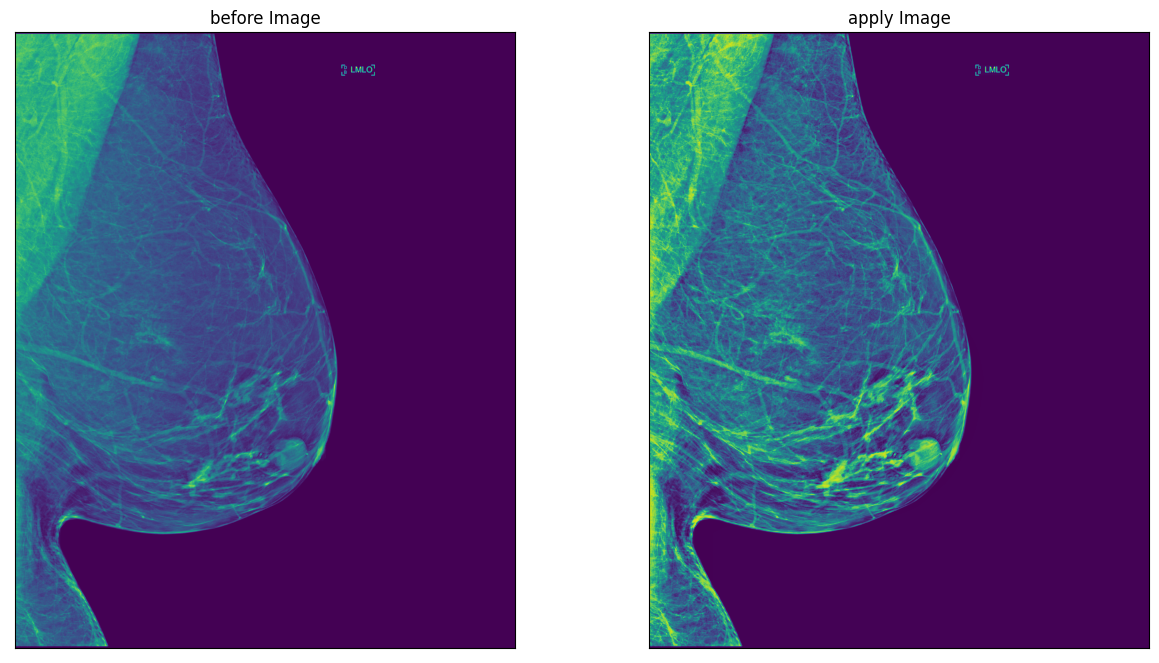

In [144]:
rows = 1
columns = 2

image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(image)

apply = ['before','apply']

img = [image, clahe_img]
for i in range(2) : 
    image_index = i + 1     # image index 
    ttitle = "{} Image".format(apply[image_index-1]) # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(ttitle)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(img[i])  
plt.show()